For this task we will be using the PubMed Multilabel Text Classification Dataset (https://www.kaggle.com/datasets/owaiskhan9654/pubmed-multilabel-text-classification). The dataset contains the titles, abstracts, and labels given by experts, of 50,000 papers in medicine found on PubMed. Those labels are used in the medicine field in order to categorize diseases or dysfunctions. As such, a paper investigating diseases that belong to axes 'A' and 'M' will receive those two labels. Out of the whole dataset, only the abstracts will be used, with the aim of trying to find clusters of similarly themed papers. In an effort to increase computation efficiency, we will use 10% of the dataset.

In [1]:
#Loading libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import regex as re 
import numpy as np
from sklearn.metrics import silhouette_score
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from umap import UMAP

In [2]:
#Loading the dataset and selecting 10% of it
df = pd.read_csv('data.csv')
df = df.sample(frac=0.1).reset_index()
df.head(5)


,index,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,...,E,F,G,H,I,J,L,M,N,Z
0,20973,"Effect of 1,25(OH)2D3 on its receptor mRNA lev...",Hormone-dependent accumulation of specific bin...,"['Alkaline Phosphatase', 'Base Sequence', 'Cal...",2153413,"[['D08.811.277.352.650.035'], ['G02.111.570.08...","['Chemicals and Drugs [D]', 'Phenomena and Pro...",1,1,1,...,1,0,1,0,0,0,1,0,0,0
1,34967,Review of streptococcal bloodstream infections...,OBJECTIVES: To determine the comparative rates...,"['Adolescent', 'Adult', 'Aged', 'Aged, 80 and ...",23182968,"[['M01.060.057'], ['M01.060.116'], ['M01.060.1...","['Named Groups [M]', 'Diseases [C]', 'Health C...",0,1,1,...,1,0,1,0,0,0,0,1,1,0
2,12445,Interaction of type IV collagen with the isola...,The triple-helical cyanogen-bromide-derived fr...,"['Amino Acid Sequence', 'Binding Sites', 'Coll...",8344274,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,36413,"Patient, Caregiver, and Clinician Perspectives...",BACKGROUND: Patients discharged from the hospi...,"['Aged', 'Caregivers', 'Female', 'Home Care Se...",30785416,"[['M01.060.116.100'], ['M01.085', 'M01.526.485...","['Named Groups [M]', 'Health Care [N]', 'Organ...",0,1,0,...,1,0,0,1,1,0,0,1,1,1
4,19276,Convection-diffusion interaction for oscillato...,Transport of soluble material is analyzed for ...,"['Biological Transport', 'Diffusion', 'Models,...",3205013,"[['G03.143'], ['G01.202', 'G02.196'], ['E05.59...","['Phenomena and Processes [G]', 'Analytical, D...",0,0,0,...,1,0,1,0,0,0,0,0,0,0


In order for the KMeans algorithm to understand our data, we need to convert them to a numerical form. We will do that by employing a TF-IDF scheme.

In [3]:
#Preprocessing
def preprocess(text):
    text = text.lower()
    t = re.sub('\W+',r' ',text)
    t = re.sub('\d',r'',t)
    t = re.sub('\s+\S\s+',r'',t)
    stopwords_list = stopwords.words('english') 
    txt = ' '.join([word for word in t.split() if word not in stopwords_list])
    return txt

lemmatizer = WordNetLemmatizer()


df['pre_abs'] = [' '.join([lemmatizer.lemmatize(preprocess(document))])
                 .strip() for document in df['abstractText']]

In [4]:
#Transforming the abstracts into vectors using TF-IDF scheme. 
#Each vector ends up having 9083 dimensions.
tfidf = TfidfVectorizer(sublinear_tf=True,max_df=0.5,min_df=5,
                        stop_words='english',norm='l2',binary=False)

X = tfidf.fit_transform(df['pre_abs'])
X.shape

(5000, 9128)

At this point we have our data in numerical form and can attempt to find clusters of similarly themed papers. We will first investigate the optimal number of clusters based on inertia.

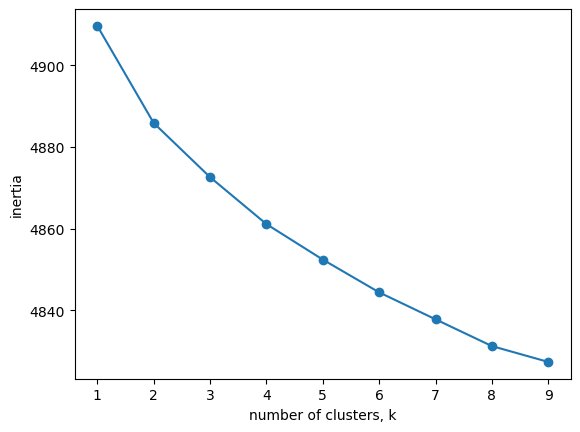

In [5]:
ks = range(1, 10)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    
    kmeans.fit(X)
    
    inertias.append(kmeans.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

We cannot notice an obvious 'elbow' effect, so we will investigate further using the silhouette coefficient score.

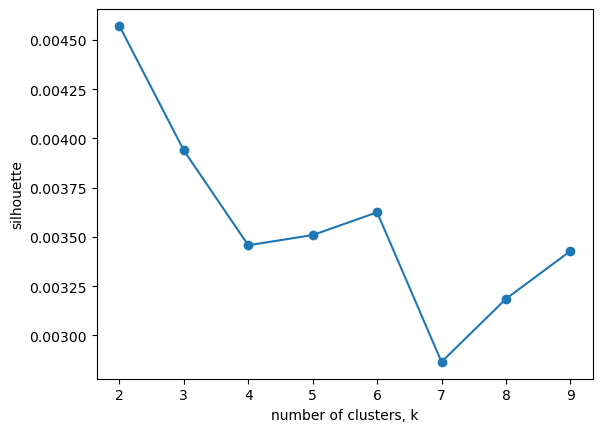

In [6]:
ks = range(2, 10)
sil = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    
    kmeans.fit(X)
    sil_score = silhouette_score(X, kmeans.labels_)
    
    sil.append(sil_score)
    
plt.plot(ks, sil, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette')
plt.xticks(ks)
plt.show()


We still notice particularly low scores. We will attempt to improve on this by reducing dimensions to 100. Even though LSA is a strong algorithm for text-based data, all abstracts have a medical underlying theme, as such the semantic analysis might underperform. Therefore, we will use UMAP.

In [7]:
X_100d = UMAP(n_components=100).fit_transform(X)
X_100d.shape

(5000, 100)

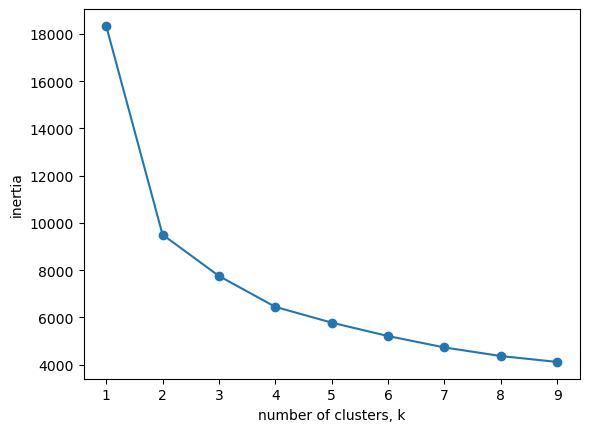

In [8]:
ks = range(1, 10)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    
    kmeans.fit(X_100d)
    
    inertias.append(kmeans.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

We seem to have an 'elbow' effect at 2 clusters.

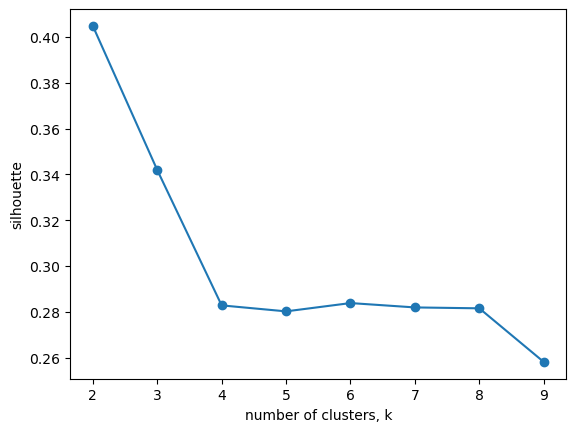

In [9]:
ks = range(2, 10)
sil = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    
    kmeans.fit(X_100d)
    sil_score = silhouette_score(X_100d, kmeans.labels_)
    
    sil.append(sil_score)
    
plt.plot(ks, sil, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette')
plt.xticks(ks)
plt.show()


Significantly improved silhouette scores, and an indication that we should use 2 clusters for our data. We can now fit our data on those clusters and see their distribution.

In [10]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_100d)
np.unique(kmeans.labels_,return_counts=True)

(array([0, 1]), array([2572, 2428], dtype=int64))

A further step would be to visualize that clustering. In order to do that we need to reduce the data dimensions further.

In [11]:
X_2d = UMAP(n_components=2).fit_transform(X)
X_2d.shape

(5000, 2)

Since we have reduced the dimensions further, we will again gauge the optimal number of clusters

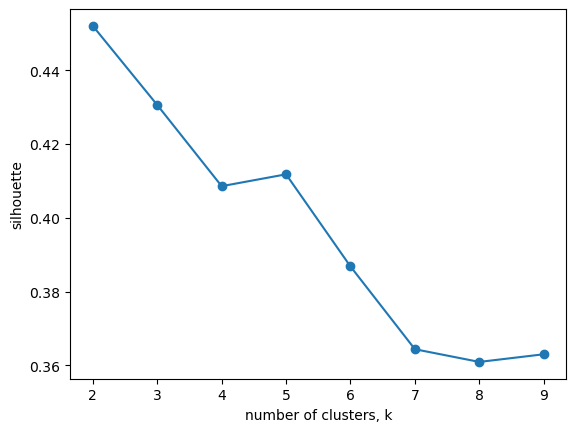

In [12]:
ks = range(2, 10)
sil = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    
    kmeans.fit(X_2d)
    sil_score = silhouette_score(X_2d, kmeans.labels_)
    
    sil.append(sil_score)
    
plt.plot(ks, sil, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette')
plt.xticks(ks)
plt.show()


An improved score that still shows the optimal cluster number as 2.

In [13]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2d)
y_pred = kmeans.predict(X_2d)
clusters = kmeans.cluster_centers_
np.unique(kmeans.labels_,return_counts=True)

(array([0, 1]), array([2588, 2412], dtype=int64))

Next we will visualize the clustering.

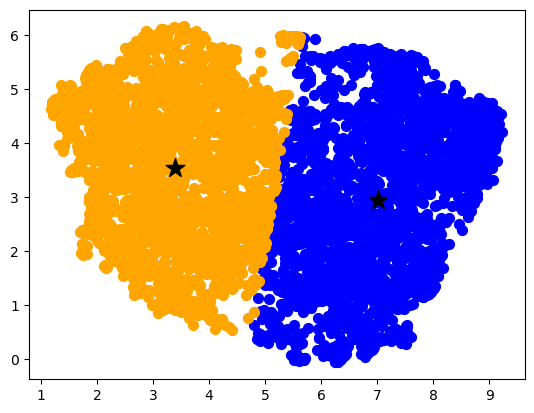

In [14]:
plt.scatter(X_2d[y_pred==0,0], X_2d[y_pred==0,1], s=50, color='blue')
plt.scatter(X_2d[y_pred==1,0], X_2d[y_pred==1,1], s=50, color='orange')
plt.scatter(clusters[0][0], clusters[0][1], marker='*', s=200, color='black')
plt.scatter(clusters[1][0], clusters[1][1], marker='*', s=200, color='black')

plt.show()

The final task will be to see if those two clusters make sense. The first approach for that will be to see if there are words that appear more often in one cluster than the other.

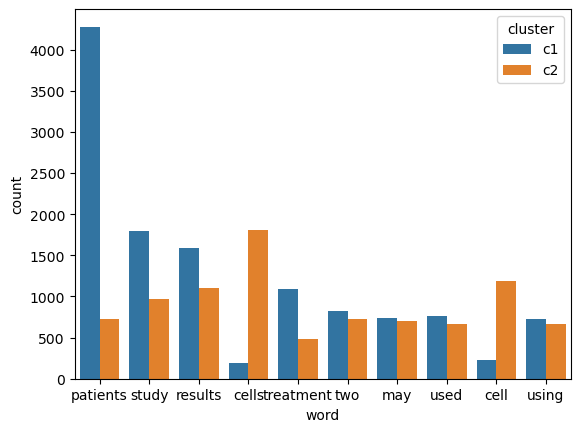

In [15]:
text = ' '.join(df['pre_abs'].values)
words = word_tokenize(text.lower())
word_counts = Counter(words)
top_words = word_counts.most_common(100)

df['pred'] = y_pred

cluster_one = ' '.join(df[df['pred'] == 0].pre_abs.values).split()
cluster_two = ' '.join(df[df['pred'] == 1].pre_abs.values).split()

count_one = Counter(cluster_one)
count_two = Counter(cluster_two)




word_list = []
c1_list = []
c2_list = []

for word, count in top_words:
    word_list.append(word)
    c1_list.append(dict(count_one)[word])
    c2_list.append(dict(count_two)[word])


c = pd.DataFrame(columns=['c1','c2'], index=word_list)
c['c1'] = c1_list
c['c2'] = c2_list

cx = c.stack().reset_index()
cx.columns = ['word','cluster','count']
sns.barplot(cx[:20],y='count',x='word',hue='cluster')
plt.show()

We can see that out of the most frequent words, most appear more often near one cluster than the other. Thus, papers that contain those words are more likely to be grouped together.

Secondly, we are going to investigate how the labels are distributed among the clusters. If the clustering makes sense, we expect, for most labels, to see a significant difference in that distribution.

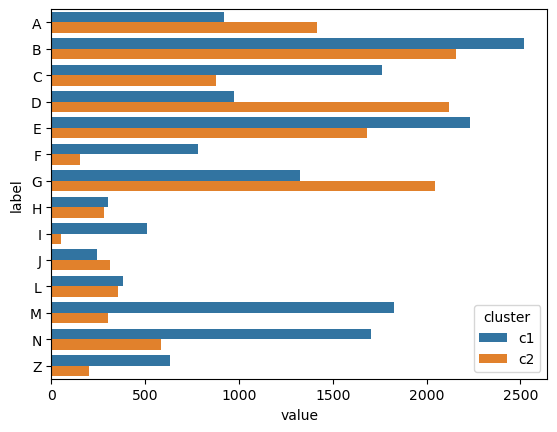

In [16]:
c1lab = df[df['pred'] == 0]
c2lab = df[df['pred'] == 1]
lab1 = pd.DataFrame(c1lab[['A','B','C','D','E','F','G',
                           'H','I','J','L','M','N','Z']]).sum()
lab2 = pd.DataFrame(c2lab[['A','B','C','D','E','F','G',
                           'H','I','J','L','M','N','Z']]).sum()
counts = pd.DataFrame({'c1':lab1,'c2':lab2}).reset_index()
counts = pd.melt(counts, id_vars=['index'], value_vars=['c1', 'c2'])
counts.rename(columns={'index':'label','variable':'cluster'},inplace=True)
sns.barplot(counts,x='value',y='label',hue='cluster')
plt.show()


Indeed, we can notice a prominent difference in the distribution of labels among the clusters. Therefore, we can assert that the clusters produced by our model do make sense.